First, we want to take the dataset from kaggle https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?resource=download and try to append the lyrics to the Dataset. 

To attach the lyrics to our data set, we use the genius.com website, as it has a very large selection of lyrics and is automatically accessible via an API. 
Unfortunately, it is probably the case that genius blocks access from shared IP-addresses (thus also Colab).
This is reported here: https://github.com/johnwmillr/LyricsGenius/issues/220
(Thanks Marian for the hint and the link).
Therefore we decided to execute the code for attaching the lyrics locally, and then upload the new, extended dataset back to colab.
dataset back into colab to be able to continue working with it there.
This notebook is therefore for running locally, as it does not work in Colab. 

We import all the necessary packages. 
Make sure that you already pip installed these in your local environment using the terminal. 

In [ ]:

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lyricsgenius as lg

from requests.exceptions import Timeout

Now we read the dataset which you can find on kaggle. 
„Spotify Tracks Dataset“ (https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?resource=download)

In [16]:
df = pd.read_csv('/Users/robertheller/Downloads/dataset2.csv')

Next, we want to import song lyrics to each song that has lyrics

The attribute instrumentalness predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 

-> from Description of dataset on kaggle. 

So let's take a look at the instrumentalness of the data:

In [17]:
df.instrumentalness.describe()

count    114000.000000
mean          0.156050
std           0.309555
min           0.000000
25%           0.000000
50%           0.000042
75%           0.049000
max           1.000000
Name: instrumentalness, dtype: float64

<Axes: ylabel='Frequency'>

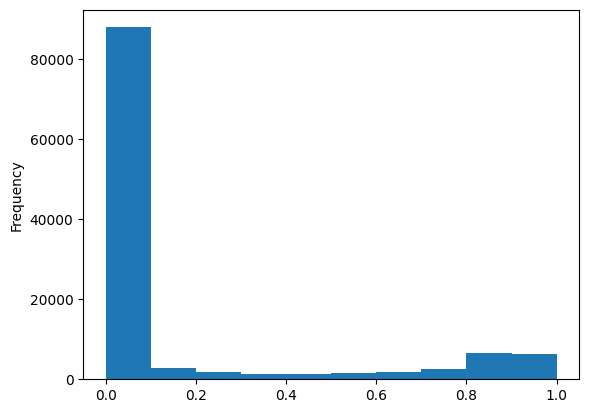

In [18]:
df.instrumentalness.plot(kind = 'hist')

We can see that most of the songs have an instrumentalness between 0 and 0.2, which means they are more vocal. This is advantageous for our project, because it means that there could be lyrics available. 

Let's see how many songs have an instrumentalness aboove 0.5:

In [19]:
df[df.instrumentalness > 0.5].count()

Unnamed: 0          18850
track_id            18850
artists             18850
album_name          18850
track_name          18850
popularity          18850
duration_ms         18850
explicit            18850
danceability        18850
energy              18850
key                 18850
loudness            18850
mode                18850
speechiness         18850
acousticness        18850
instrumentalness    18850
liveness            18850
valence             18850
tempo               18850
time_signature      18850
track_genre         18850
dtype: int64

Now, let's drop those songs because it is very unlikely that we will find lyrics for these songs

In [20]:
df_vocal = df[~(df.instrumentalness > 0.5)]


Let's also check for duplicates in the dataset:

In [21]:
df_vocal.duplicated().sum()

0

Since there are no duplicates, let's also check the NA's:

In [22]:
df_vocal.isna().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Drop the NA's

In [23]:
df_vocal = df_vocal.dropna()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113993,113993,4OkMK49i3NApR1KsAIsTf6,Chris Tomlin,See The Morning (Special Edition),How Can I Keep From Singing,39,256026,False,0.505,0.6870,...,-4.375,1,0.0287,0.0841,0.000000,0.1880,0.382,104.083,3,world-music
113994,113994,4WbOUe6T0sozC7z5ZJgiAA,Lucas Cervetti,Frecuencias Álmicas en 432hz,"Frecuencia Álmica, Pt. 4",22,305454,False,0.331,0.1710,...,-15.668,1,0.0350,0.9200,0.022900,0.0679,0.327,132.147,3,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.743,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.413,135.960,4,world-music


In [24]:
df_vocal.isna().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

For this project, we want to focus on english songs only. It is one of the most spoken languages and has the highest probability that we will find lyrics for the songs. It also simplifies the sentiment analysis of the lyrics, because most pretrained models are used for english language. 


Since the process of appending lyrics takes very long, we want to minimize the risk of not finding any lyrics for the given song. Therefore we eliminate all songs, that contain non-english letters in the title. 
It would be too difficult to handle multiple languages at once. 
Therefore we define the check_english_letters function:

In [25]:

def check_english_letters(text):
    if isinstance(text, str):
        pattern = re.compile(r'[^\x00-\x7F]') #match any character that is not in the ASCII range of English letters and characters. If a match is found, it means non-English letters or symbols are present in the text.
        match = re.search(pattern, text)
        if match:
            return False  # Non-English letters or symbols found
        else:
            return True  # Contains only English letters and characters
    else:
        return True  # Treat non-string values as English

Now let's apply this function to the dataset:

In [26]:
df_vocal['is_english'] = df['track_name'].apply(check_english_letters)

/var/folders/jv/bcpp1tsj2dzcqjcz4hn9m74r0000gn/T/ipykernel_65678/2418032644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vocal['is_english'] = df['track_name'].apply(check_english_letters)


In [27]:
df_vocal.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,95150.000000,95150.000000,9.515000e+04,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000,95150.000000
mean,57919.471908,34.139727,2.223813e+05,0.579705,0.660315,5.318781,-7.362085,0.647042,0.088499,0.300482,0.023704,0.219903,0.508714,122.756298,3.918056
std,32319.205464,22.762215,8.924526e+04,0.160298,0.228585,3.559788,3.733331,0.477892,0.112876,0.311330,0.077543,0.194375,0.246809,29.768849,0.390107
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-43.046000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30760.250000,18.000000,1.759860e+05,0.474000,0.502000,2.000000,-9.130000,0.000000,0.035300,0.022100,0.000000,0.098800,0.310000,99.706000,4.000000
50%,58760.000000,36.000000,2.115730e+05,0.587000,0.695000,5.000000,-6.580000,1.000000,0.049200,0.171000,0.000006,0.138000,0.504000,122.001000,4.000000
75%,86335.750000,51.000000,2.541820e+05,0.696000,0.852000,8.000000,-4.791000,1.000000,0.088800,0.555000,0.001060,0.286000,0.706000,141.819000,4.000000
max,113999.000000,100.000000,4.339826e+06,0.985000,1.000000,11.000000,2.574000,1.000000,0.965000,0.996000,0.500000,1.000000,0.994000,222.605000,5.000000


In [28]:
df_vocal = df_vocal[(df_vocal.is_english == True)]
df_vocal

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_english
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,True
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,True
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,True
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,True
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113992,113992,3FjOBB4EyIXHYUtSgrIdY9,Jesus Culture,Revelation Songs,Your Love Never Fails,38,312566,False,0.475,0.8600,...,1,0.0421,0.0065,0.000002,0.2460,0.427,113.949,4,world-music,True
113993,113993,4OkMK49i3NApR1KsAIsTf6,Chris Tomlin,See The Morning (Special Edition),How Can I Keep From Singing,39,256026,False,0.505,0.6870,...,1,0.0287,0.0841,0.000000,0.1880,0.382,104.083,3,world-music,True
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,0,0.0420,0.8670,0.000000,0.0839,0.743,132.378,4,world-music,True
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,1,0.0297,0.3810,0.000000,0.2700,0.413,135.960,4,world-music,True


Now let's try to add the lyrics to the dataframe:
We will be using the genius.com library, which utilizes the genius API
source: https://www.youtube.com/watch?v=cU8YH2rhN6A&ab_channel=elbert

In order to access genius.com, we need a access token for the API. We have to set this as an environment variable. For this, we use the os package.

In [29]:
os.environ['GENIUS_ACCESS_TOKEN']='l3qvhXoAyw_SW4dgRjZLCGxa5f-hUYEkgU3riVKxc1erYuGWgr8nzy9wAzX9LnRK'
genius_access_token = os.environ['GENIUS_ACCESS_TOKEN']

Now, let's create our genius object and try to find the lyrics for the song "Diamonds" by Rihanna (as an example):

In [30]:
genius = lg.Genius(genius_access_token)
song = genius.search_song(title = 'Diamonds', artist = 'Rihanna')
lyrics = song.lyrics
print(lyrics)


Searching for "Diamonds" by Rihanna...
Done.
120 ContributorsTranslationsPortuguêsΕλληνικάEnglishBahasa IndonesiaDiamonds Lyrics[Intro]
Shine bright like a diamond
Shine bright like a diamond

[Verse 1]
Find light in the beautiful sea
I choose to be happy
You and I, you and I, we're like diamonds in the sky
You're a shooting star I see, a vision of ecstasy
When you hold me, I'm alive, we're like diamonds in the sky

[Pre-Chorus]
I knew that we'd become one right away
Oh, right away
At first sight, I felt the energy of sun rays
I saw the life inside your eyes

[Chorus]
So shine bright, tonight, you and I
We're beautiful, like diamonds in the sky
Eye to eye, so alive
We're beautiful, like diamonds in the sky

[Post-Chorus]
Shine bright like a diamond (Woah)
Shine bright like a diamond (Woah)
Shinin' bright like a diamond
We're beautiful, like diamonds in the sky
Shine bright like a diamond (Woah)
Shine bright like a diamond (Woah)
Shinin' bright like a diamond
We're beautiful, like diamo

Since we want to iterate through all available lyrics for each row in the dataset, we need to write a function so we can apply it to the dataframe:

In [33]:
def lyrics(title, artist):
    os.environ['GENIUS_ACCESS_TOKEN'] = 'ac_Jy197DPsLRDJC_lVeV3V4c1Bg0IFluavOIzHGlBY3aF7Q-_fozn6onGe9LHrS'
    # we define the genius access token as a environmental variable. We get the token after registering on the https://genius.com/api-clients website. 
    genius_access_token = os.environ['GENIUS_ACCESS_TOKEN']
    genius = lg.Genius(access_token = genius_access_token, timeout = 10)

    while True:         # The reason we have to include a try and except command is because the searching sometimes raises Timeout Errors at random moments. Because of this, we use the try&except method to ensure that the query doesnt break because of a timeout error, but can continue the search. This is critical since we have a long dataset and the queries take a long time. 
        try:
            song = genius.search_song(title=title, artist=artist)
            break  # If no exception is raised, break out of the loop
        except Timeout:
            print("Timeout occurred. Retrying...")
            continue  # If a timeout exception is raised, retry the loop

    if song is None: #if the search couldnt find the song we provided, the function genius.search_song returns 'None'. 
        return np.nan  # sometimes the search cannot find any song in the genius database. If this happens, the query should just fill the value with an empty value and not break out of the loop. This way we can be sure that the searching can continue. 
    else:
        return song.lyrics # if the search was successful in the genius database, we want to get the song lyrics. 





Now, let's try to run the code on a very small set of data. 
For this, we create a sample dataframe containing 10 rows. 

In [31]:
df_sample = df_vocal.head(10)

We can run the code for the small dataset:

In [34]:


# This code runs the query of the genius lyrics for the entire df_sample dataset.
df_sample['lyrics'] = df_sample.apply(lambda row: lyrics(row['track_name'], row['artists']), axis =1)
df_sample.head()


Searching for "Comedy" by Gen Hoshino...
Done.
Searching for "Ghost - Acoustic" by Ben Woodward...
No results found for: 'Ghost - Acoustic Ben Woodward'
Searching for "To Begin Again" by Ingrid Michaelson;ZAYN...
Done.
Searching for "Can't Help Falling In Love" by Kina Grannis...
Done.
Searching for "Hold On" by Chord Overstreet...
Done.
Searching for "Days I Will Remember" by Tyrone Wells...
Done.
Searching for "Say Something" by A Great Big World;Christina Aguilera...
Done.
Searching for "I'm Yours" by Jason Mraz...
Timeout occurred. Retrying...
Searching for "I'm Yours" by Jason Mraz...
Timeout occurred. Retrying...
Searching for "I'm Yours" by Jason Mraz...
Done.
Searching for "Lucky" by Jason Mraz;Colbie Caillat...
Done.
Searching for "Hunger" by Ross Copperman...
Done.


/var/folders/jv/bcpp1tsj2dzcqjcz4hn9m74r0000gn/T/ipykernel_65678/3974938475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['lyrics'] = df_sample.apply(lambda row: lyrics(row['track_name'], row['artists']), axis =1)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_english,lyrics
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,True,1 ContributorComedy (Remix) Lyrics[Verse 1]\n争...
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,True,NaN
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,True,31 ContributorsTranslationsNorsk (bokmål / rik...
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,True,7 ContributorsCan’t Help Falling in Love Lyric...
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,True,91 ContributorsHold On Lyrics[Verse 1]\nLoving...


But in order to use the whole dataset and not just a small sample dataset, we can alternatively split the dataset into chunks and run the query by iterating through the different chunks of the dataset

Since the code takes a long time to run, we decided to take a sample of 10.000 rows for our analysis, since this should be sufficient for our purpose.  

In [ ]:
df_sample = df_vocal.sample(10000)

In [35]:
chunk_size = 100  # Number of rows to process in each iteration
num_chunks = (len(df_sample) - 1) // chunk_size + 1

# Create an empty list to store the chunk dataframes
chunk_dfs = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = min((i + 1) * chunk_size, len(df_sample))
    df_chunk = df_sample.iloc[start_index:end_index].copy()

    try:
        # Apply lyrics function while handling float values
        df_chunk['lyrics'] = df_chunk.apply(
            lambda row: lyrics(row['track_name'], row['artists'])
            if isinstance(row['track_name'], str) and isinstance(row['artists'], str)
            else np.nan,
            axis=1
        )

        # Append the chunk dataframe to the list
        chunk_dfs.append(df_chunk)
    except KeyError:
        continue

# Concatenate all the chunk dataframes into a single dataframe
df_result = pd.concat(chunk_dfs)

# Update the 'lyrics' column in df_sample with the values from df_result
df_sample['lyrics'] = df_result['lyrics']



Searching for "Comedy" by Gen Hoshino...
Done.
Searching for "Ghost - Acoustic" by Ben Woodward...
No results found for: 'Ghost - Acoustic Ben Woodward'
Searching for "To Begin Again" by Ingrid Michaelson;ZAYN...
Done.
Searching for "Can't Help Falling In Love" by Kina Grannis...
Done.
Searching for "Hold On" by Chord Overstreet...
Done.
Searching for "Days I Will Remember" by Tyrone Wells...
Done.
Searching for "Say Something" by A Great Big World;Christina Aguilera...
Done.
Searching for "I'm Yours" by Jason Mraz...
Done.
Searching for "Lucky" by Jason Mraz;Colbie Caillat...
Done.
Searching for "Hunger" by Ross Copperman...
Done.
Searching for "Give Me Your Forever" by Zack Tabudlo...


/var/folders/jv/bcpp1tsj2dzcqjcz4hn9m74r0000gn/T/ipykernel_65678/106859569.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.loc[start_index:end_index, 'lyrics'] = df_chunk['lyrics']


Done.
Searching for "I Won't Give Up" by Jason Mraz...
Done.
Searching for "Solo" by Dan Berk...
Done.
Searching for "Bad Liar" by Anna Hamilton...
Done.
Searching for "Hold On - Remix" by Chord Overstreet;Deepend...
Done.
Searching for "Falling in Love at a Coffee Shop" by Landon Pigg...
Done.
Searching for "ily (i love you baby)" by Andrew Foy;Renee Foy...
No results found for: 'ily (i love you baby) Andrew Foy;Renee Foy'
Searching for "At My Worst" by Andrew Foy;Renee Foy...
No results found for: 'At My Worst Andrew Foy;Renee Foy'
Searching for "Lucky" by Jason Mraz;Colbie Caillat...
Done.
Searching for "Photograph" by Boyce Avenue;Bea Miller...
Done.
Searching for "I'm Yours" by Jason Mraz...
Done.
Searching for "Demons" by Boyce Avenue;Jennel Garcia...
No results found for: 'Demons Boyce Avenue;Jennel Garcia'
Searching for "Say Something" by A Great Big World;Christina Aguilera...
Done.
Searching for "93 Million Miles" by Jason Mraz...
Done.
Searching for "Unlonely" by Jason Mraz.

In [36]:
# Now we want to see if everything worked out
df_sample.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_english,lyrics
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,True,1 ContributorComedy (Remix) Lyrics[Verse 1]\n争...
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,True,NaN
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,True,31 ContributorsTranslationsNorsk (bokmål / rik...
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,True,7 ContributorsCan’t Help Falling in Love Lyric...
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,True,91 ContributorsHold On Lyrics[Verse 1]\nLoving...


In [60]:
# Now we want to save our new dataset which contains the lyrics in a new csv file which we can use to upload to colab and continue our work on the data. 
df_sample.to_csv('/Users/robertheller/Desktop/lyrics/export csv/dfsample.csv')
